This notebook outlines the steps needed to change the resolution of the 2D domain.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

%matplotlib inline

# Changing the Vertical resolution 
To change the vertical resolution, you need to work through the followinh steps.

1. Set new resolution in NEMO.
2. Interpolate initial conditions onto new grid.
3. Interpolate bounday conditions onto new grid.


## 1. Set new resolution in NEMO

###a. Choose the grid levels.
The vertical resolution is set through a number of options in the namelist.domain.

    ppsur       = 999999.
    ppa0        = 999999.
    ppa1        = 999999.
    ppkth       = 25.
    ppacr       =  3.
    ldbletanh   = .FALSE.   ! use double tanh true or false
    ppa2        =  0  Double tanh function parameters
    ppkth2      =  0     
    ppacr2      =  0  
    
These parameters set the grid spacing and depth at each grid level as defined by:

$$ z(k) = ppsur + ppa0k + ppa1 ppacr \log(\cosh(\frac{k-ppkth}{ppacr})) + ppa2 ppacr2 \log\cosh(\frac{k-ppkth2} {ppacr2})) $$ 

$$ e3(k) = |+ ppa0k + ppa1 \tanh(\frac{k-ppkth}{ppacr}) + ppa2\tanh(\frac{k-ppkth2}{ppacr2}) |$$

where $k$ is the grid level, $z(k)$ is the depth of the grid level, and $e3(k)$ is the grid spacing at that grid level (NEMO manual). Note that the second hyperbolic tan is only used if ldbletanh=.TRUE.

Note: ppsur should be set so that z(1) = 0

You should experirment with these settings in a notebook.  Here is an example of a double tanh profile.

ppsur -83.1898878903
ppa0 8.19973820108
Surface:  1.42108547152e-14
First grid cell thickness 1.0
Bottom: 428.789503531


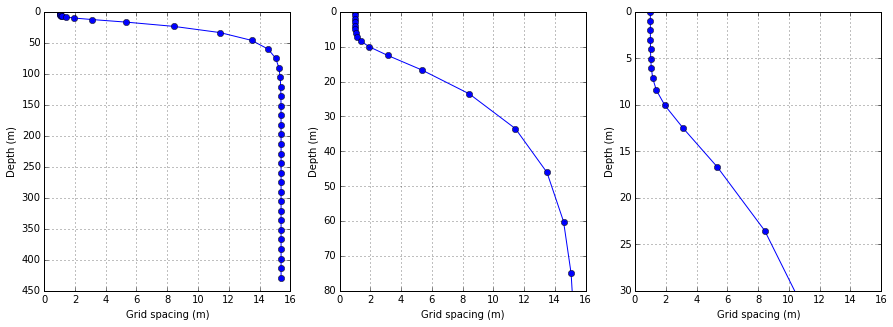

In [2]:
ks = np.arange(1,41) # Remember Fortan starts counting at 1.

#Parameters
ppa1 = 0.5
ppacr = 2.
ppkth = 12
ppa2 = 6.7
ppacr2 =2.2
ppkth2 = 13.
#ensure first grid cell has spacing 1
ppa0 =  1 - ppa1*np.tanh((ks[0]-ppkth)/ppacr)  - ppa2*np.tanh((ks[0]-ppkth2)/ppacr2)
#ensure first grid point is at the surface (0)
ppsur = - (ppa0 + ppa1*ppacr*np.log(np.cosh((ks[0]-ppkth)/ppacr)) + ppa2*ppacr2*np.log(np.cosh((ks[0]-ppkth2)/ppacr2)))

#define grid spacing (dzs) and grid levels (zs)
dzs =   ppa0 + ppa1*np.tanh((ks-ppkth)/ppacr) + ppa2*np.tanh((ks-ppkth2)/ppacr2)
zs = ppsur + ppa0*ks + ppa1*ppacr*np.log(np.cosh((ks-ppkth)/ppacr)) + ppa2*ppacr2*np.log(np.cosh((ks-ppkth2)/ppacr2))

#plot
fig,axs=plt.subplots(1,3,figsize=(15,5))
for ax in axs:
    ax.plot(dzs,zs,'-o')
    ax.grid()
    ax.set_xlabel('Grid spacing (m)')
    ax.set_ylabel('Depth (m)')
axs[0].set_ylim([450,0])
axs[1].set_ylim([80,0])
axs[2].set_ylim([30,0])
print 'ppsur', ppsur
print 'ppa0', ppa0
print 'Surface: ',zs[0]
print 'First grid cell thickness', dzs[0]
print 'Bottom:', zs[-1]

###b. Generate mesh_mask.nc file for interpolation
Now that that you have decided on a different vertical grid structure, add the above parameters to your namelist.domain and set up a "fake" simulation. The purpose of the fake simulation is to generate a new mesh_mask.nc file which contains the grids for your new domain. Once you have the new grid, you can interpolate the boundary and initial conditions. 

Run NEMO with nn_msh = 1 in namelist.domain. You only need to run a short simulation (one time step). This will generate a file called mesh_mask.nc

Copy this file into the workspace where you'll be interpolating the boudnary conditions and initial conditions.

#2. Interpolate initial conditions

The new mesh gives us the z-levels needed for interpolation. Choose your initial condition file to interpolate.

Open old dataset

In [10]:
#open old file
fold = nc.Dataset('/data/nsoontie/MEOPAR/2Ddomain/initial_conditions/TS_uniform_36.nc')
Sold = fold.variables['vosaline'][:]
Told = fold.variables['votemper'][:]
#masking
Sold = np.ma.masked_values(Sold,0)
Told = np.ma.masked_values(Told,0)
#old grid
f=nc.Dataset('/data/nsoontie/MEOPAR/2Ddomain/grid/mesh_mask.nc')
gdept_old = f.variables['gdept_0'][0,:]
print gdept_old

[   0.50000027    1.50000314    2.5000115     3.50003055    4.50007042
    5.50015083    6.50031022    7.50062342    8.50123623    9.50243254
   10.5047653    11.50931127   12.51816684   13.53541212   14.56898216
   15.63428737   16.76117342   18.00713456   19.48178514   21.38997868
   24.10025665   28.22991514   34.68575798   44.51772486   58.48433368
   76.58558445   98.06295924  121.8665184   147.08945807  173.11448217
  199.57304923  226.26030574  253.06663733  279.93454976  306.83419736
  333.75016973  360.6745318   387.60320347  414.53408835  441.46610968]


Open new mesh file

In [11]:
mesh = nc.Dataset('/data/nsoontie/MEOPAR/2Ddomain/vertical_resolution/dbl_tanh/mesh_mask.nc')
gdept = mesh.variables['gdept_0'][0,:,:,:]
e3t = mesh.variables['e3t_0'][0,:,:,:]
# multi dimensional because of patrial cells
print gdept[:,0,0]

[   0.50003511    1.50045013    2.50187922    3.50584388    4.51615047
    5.54231215    6.60804415    7.77197409    9.17587852   11.14406872
   14.32758141   19.71521759   28.14229202   39.53160858   52.97109604
   67.5062027    82.54394531   97.79561615  113.13538361  128.51092529
  143.90090942  159.29672241  174.69488525  190.09399414  205.49346924
  220.89311218  236.2928009   251.69252014  267.09225464  282.49200439
  297.89172363  313.29147339  328.69119263  344.09094238  359.49069214
  374.89041138  390.29016113  405.68991089  421.08963013  436.48937988]


Interpolate

In [18]:
Tnew = np.copy(Told)
Snew = np.copy(Sold)
for j in np.arange(Tnew.shape[2]):
    for i in np.arange(Tnew.shape[3]):
        Tnew[0,:,j,i] = np.interp(gdept[:,j,i], gdept_old, Told[0,:,j,i])
        Snew[0,:,j,i] = np.interp(gdept[:,j,i], gdept_old, Sold[0,:,j,i])

Check it makes sense

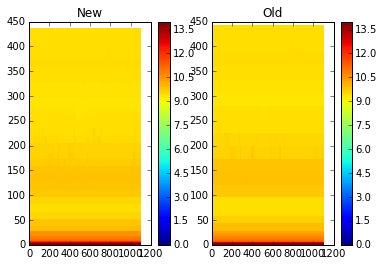

In [22]:
vmin=0;vmax=14
fig,axs =plt.subplots(1,2)
mesh=axs[0].pcolormesh(np.arange(Tnew.shape[-1]),gdept[:,5,:],Tnew[0,:,5,:],vmin=vmin,vmax=vmax)
plt.colorbar(mesh,ax=axs[0])
axs[0].set_title('New')
mesh=axs[1].pcolormesh(np.arange(Told.shape[-1]),gdept_old[:],Told[0,:,5,:],vmin=vmin,vmax=vmax)
plt.colorbar(mesh,ax=axs[1])
axs[1].set_title('Old')

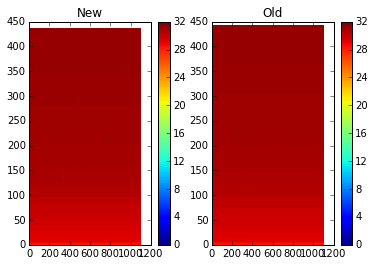

In [21]:
vmin=0;vmax=32
fig,axs =plt.subplots(1,2)
mesh=axs[0].pcolormesh(np.arange(Snew.shape[-1]),gdept[:,5,:],Snew[0,:,5,:],vmin=vmin,vmax=vmax)
plt.colorbar(mesh,ax=axs[0])
axs[0].set_title('New')
mesh=axs[1].pcolormesh(np.arange(Sold.shape[-1]),gdept_old[:],Sold[0,:,5,:],vmin=vmin,vmax=vmax)
plt.colorbar(mesh,ax=axs[1])
axs[1].set_title('Old')

Save in a new file